Colab의 경우 아래 라이브러리를 기본적으로 지원하기 때문에 Colab 사용자는 아래의 설치 명령어를 실행할 필요가 없다.

In [ ]:
#!pip install -q tensorflow-hub
#!pip install -q tfds-nightly

In [2]:
import tensorflow as tf
import numpy as np

import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [3]:
print("tensorflow version: ", tf.__version__)
print("Eagerly executing mode: ", tf.executing_eagerly())
print("hub version: ", hub.__version__)
print("GPU", "able" if tf.config.experimental.list_physical_devices("GPU") else "not able")

"""
colab에서 GPU, TPU 등 런타임 유형을 조절할 수 있음
상단 메뉴바에서 "런타임" >> "런타임 유형 변경"
"""

tensorflow version:  2.3.0
Eagerly executing mode:  True
hub version:  0.9.0
GPU able


In [4]:
train_data, validation_data, test_data = tfds.load(
    name = "imdb_reviews",
    split = ('train[:60%]', 'train[60%:]', 'test'),
    as_supervised = True
)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4QENRJ/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4QENRJ/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4QENRJ/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [6]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>


# 튜토리얼에서 사용하는 사전 훈련 모델
- google/tf2-preview/gnews-swivel-20dim/1

# 또 다른 모델
- google/tf2-preview/gnews-swivel-20dim-with-oov/1 - 위 모델과 동일하지만 어휘 사전(vocabulary)의 2.5%가 OOV 버킷(bucket)으로 변환, 해당 문제의 어휘 사전과 모델의 어휘 사전이 완전히 겹치지 않을 때 도움이 됨.
- google/tf2-preview/nnlm-en-dim50/1 - 더 큰 모델, 차원 크기는 50, 어휘 사전의 크기는 1백만 개 이하.
- google/tf2-preview/nnlm-en-dim128/1 - 훨씬 더 큰 모델, 차원 크기는 128, 어휘 사전의 크기는 1백만 개 이하.

In [7]:
# hub를 이용해 이미 저장된 모델을 사용하는 방법
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")
embeddings = embed(["cat is on the mat", "dog is in the fog"])
print(embeddings)

tf.Tensor(
[[ 0.8666395   0.35917717  0.00579667  0.681002   -0.54226625  0.22343189
  -0.38796625  0.62195706  0.22117122 -0.48538068 -1.2674141   0.886369
  -0.32849073 -0.13924702 -0.53327686  0.5739708  -0.05905761  0.13629246
  -1.1718255  -0.31494334]
 [ 0.9602181   0.62520486  0.06261905  0.37425604  0.24782333 -0.39351934
  -0.7418429   0.56599647 -0.26197797 -0.69016844 -0.76565284  0.71412426
  -0.4537978  -0.50701594 -0.8499377   0.8917156  -0.30278975  0.2149126
  -1.1098894  -0.46719775]], shape=(2, 20), dtype=float32)


In [8]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

hub_layer = hub.KerasLayer(
    embedding,
    input_shape = [],
    dtype = tf.string,
    trainable = True
)

hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [13]:
history = model.fit(
    train_data.shuffle(10000).batch(512),
    epochs = 20,
    validation_data = validation_data.batch(512),
    verbose = 1
)

Epoch 1/20
30/30 [==============================] - 2s 78ms/step - loss: 5.2552 - accuracy: 0.4931 - val_loss: 4.4690 - val_accuracy: 0.5402
Epoch 2/20
30/30 [==============================] - 2s 68ms/step - loss: 3.3082 - accuracy: 0.5739 - val_loss: 2.6470 - val_accuracy: 0.6147
Epoch 3/20
30/30 [==============================] - 2s 68ms/step - loss: 2.0657 - accuracy: 0.6536 - val_loss: 1.7270 - val_accuracy: 0.6775
Epoch 4/20
30/30 [==============================] - 2s 70ms/step - loss: 2.2036 - accuracy: 0.6527 - val_loss: 4.3066 - val_accuracy: 0.5789
Epoch 5/20
30/30 [==============================] - 2s 68ms/step - loss: 2.9076 - accuracy: 0.6349 - val_loss: 1.6205 - val_accuracy: 0.6708
Epoch 6/20
30/30 [==============================] - 2s 67ms/step - loss: 2.2300 - accuracy: 0.6465 - val_loss: 3.4889 - val_accuracy: 0.5695
Epoch 7/20
30/30 [==============================] - 2s 72ms/step - loss: 1.7154 - accuracy: 0.6781 - val_loss: 1.8301 - val_accuracy: 0.6445
Epoch 8/20
30

In [20]:
results = model.evaluate(test_data.batch(512), verbose = 2)

for name, value in zip(model.metrics_names, results):
  print("{} {:.3f}".format(name, value))

49/49 - 2s - loss: 0.7897 - accuracy: 0.7362
loss 0.790
accuracy 0.736


In [16]:
history_dict = history.history

for k, v in history_dict.items():
  print(k)

loss
accuracy
val_loss
val_accuracy


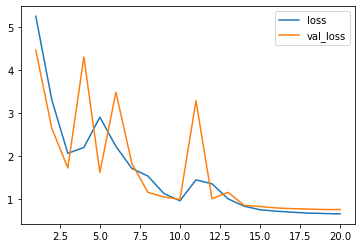

In [18]:
import matplotlib.pyplot as plt

x_lab = range(1,21)
plt.figure()
plt.plot(x_lab, history_dict["loss"], label = "loss")
plt.plot(x_lab, history_dict["val_loss"], label = "val_loss")
plt.legend()
plt.show()

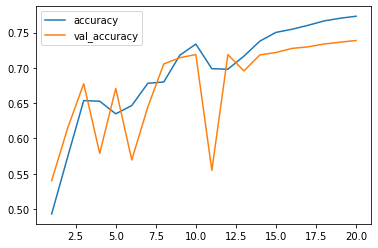

In [19]:
x_lab = range(1,21)
plt.figure()
plt.plot(x_lab, history_dict["accuracy"], label = "accuracy")
plt.plot(x_lab, history_dict["val_accuracy"], label = "val_accuracy")
plt.legend()
plt.show()